# Importing Packages

In [168]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np 
import seaborn as sns
def extract_temperature(text_temp):
    if text_temp == ' --- ':
        return None
    return float(text_temp[:text_temp.index('°')-1].strip())

def format_date(date,month,year):
    day = date[:date.index('.')]
    full_date = f"{date[-2:].replace(' ','0')}-{('0'+str(month))[-2:]}-{year}"
    return day,full_date
def extract_sum_cyclist(data):
    s= 0
    d = data["results"][0]["date"] 
    date = d[:d.index('T')]
    for dat in data["results"]:
        s+= dat["sum_counts"]
    return s,date

# Scrapping the Temperature

In [ ]:

tmin = []
tmax = []
dates = []
days = []

years = range(2019,2026)
months = range(1,13)
for year in years:
    for month in months:
        # print(f"{month}-{year}")
        url = f"https://www.meteociel.fr/climatologie/obs_villes.php?code2=75107005&mois={month}&annee={year}&sn=0"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        table  = soup.find("table",style="border-collapse: collapse")
        if table:
            rows = table.find_all("tr")[1:-1]
            for row in rows:
                tmin.append(extract_temperature(row.find("td",bgcolor="#FFDDDD").text))
                tmax.append(extract_temperature(row.find("td",bgcolor="#DDDDFF").text))
                day,date = format_date(row.find("td",bgcolor="#FFFFCC").text,month,year)
                dates.append(date)
                days.append(day) 
df = pd.DataFrame({
                    "date": dates,
                    "day": days,
                    "tmin" : tmin,
                    "tmax": tmax
                  })
df.to_csv("MinMax_temperature_2019_2025")

In [143]:
df

,date,day,tmin,tmax
0,01-01-2019,Mar,6.5,5.2
1,02-01-2019,Mer,4.5,3.1
2,03-01-2019,Jeu,3.9,2.7
3,04-01-2019,Ven,3.4,1.8
4,05-01-2019,Sam,3.4,1.6
...,...,...,...,...
2485,18-12-2025,Jeu,13.5,5.4
2486,19-12-2025,Ven,10.1,8.5
2487,20-12-2025,Sam,9.3,6.6
2488,21-12-2025,Dim,11.6,8.4


# Getting the Cyclists Counts from API

In [137]:
dates = []
counts = []
years = range(2024,2026)
months = range(1,13)
days = [('0'+str(d))[-2:] for d in range(1,32)]
for year in years:
    for month in months:
        for day in days:
                print(f"{day}-{month}-{year}",end="\r")
                url = "https://opendata.paris.fr" + \
                        "/api/explore/v2.1/catalog/datasets/comptage-velo-donnees-compteurs/" + \
                        f"records?limit=48&refine=name%3A%2236%20quai%20de%20Grenelle%22&refine=date%3A%22{year}%2F{month}%2F{day}%22"
                response = requests.get(url)
                if response.status_code==200:
                        data = response.json()
                        if data["total_count"]>0:                     
                                count,date = extract_sum_cyclist(data)
                                dates.append(date)
                                counts.append(count)                                
df_cyclist = pd.DataFrame({
                    "date": dates,
                    "count": counts
                  })
df_cyclist.to_csv("Cyclists_count")

In [138]:
df_cyclist

,date,count
0,2024-11-01,2359
1,2024-11-02,2703
2,2024-11-03,2592
3,2024-11-04,4996
4,2024-11-05,5380
...,...,...
411,2025-12-17,4817
412,2025-12-18,4968
413,2025-12-19,3649
414,2025-12-20,1921


# Merging the 2 Datasets

## Importing

In [171]:
temperature = pd.read_csv("MinMax_temperature_2019_2025")
cyclist = pd.read_csv("Cyclists_count")

## Formatting

In [172]:
cyclist.date= pd.to_datetime(cyclist.date, format='%Y-%m-%d')
cyclist.index = cyclist.date
cyclist.drop(columns=["Unnamed: 0","date"],inplace=True)
temperature.date= pd.to_datetime(temperature.date, format='%d-%m-%Y')
temperature.index = temperature.date
temperature = temperature[["day","tmin","tmax"]]


In [173]:
df_merged = temperature.merge(cyclist,how="inner",left_on=temperature.index,right_on=cyclist.index)
df_merged.rename(columns={"key_0":"date"},inplace=True)
df_merged.to_csv("project_dataset")

<Axes: xlabel='date', ylabel='count'>

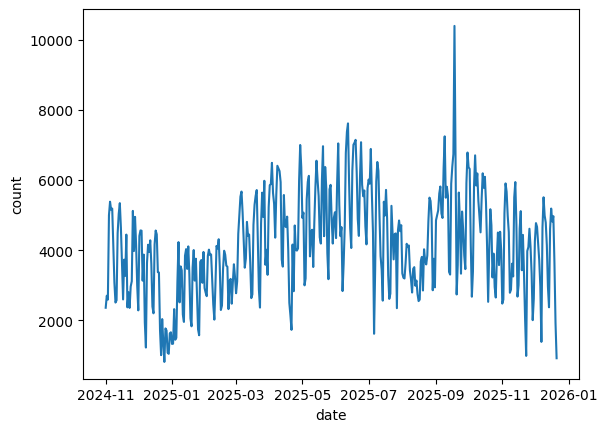

In [174]:
sns.lineplot(data=df_merged,
             x="date",
             y = "count")